In [1]:
!nvidia-smi

Thu Mar  5 17:21:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0  On |                  N/A |
| 45%   28C    P8    N/A /  75W |    304MiB /  4038MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install -q tensorflow-gpu==2.1.0

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
%run Model.ipynb
%run DataGenerator.ipynb
%run FileTransformer.ipynb
import os
import datetime
import string

In [133]:
class FilePaths:
    iam_path = os.path.join("..","raw","iam")
    source_path = os.path.join("..", "data", "iam.hdf5")
    output_path = os.path.join("..", "output")
    target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
    model_saved_path = os.path.join("..", "output", "saved_model.h5")
    test_image_path = os.path.join("..", "data", "test.png")
    test_image_preprocessed_path = os.path.join("..", "output", "preprocessed_test.png")
    cnn_1_weights_path = os.path.join("..", "output", "cnn_weights_1.png")
    cnn_2_weights_path = os.path.join("..", "output", "cnn_weights_2.png")
    cnn_1_outputs = os.path.join("..", "output", "cnn_1_outputs.png")
    cnn_2_outputs = os.path.join("..", "output", "cnn_2_outputs.png")
    cnn_3_outputs = os.path.join("..", "output", "cnn_3_outputs.png")
    cnn_4_outputs = os.path.join("..", "output", "cnn_4_outputs.png")
    cnn_5_outputs = os.path.join("..", "output", "cnn_5_outputs.png")
    

input_size = (1024, 128, 1)

In [6]:
ds = Dataset(iam_path=FilePaths.iam_path)

ds.read_iam()

ds.preprocess_partitions(input_size=input_size)

ds.save(source_path = FilePaths.source_path)

Partitions will be preprocessed...
Partitions preprocessing finished
[OK] train partition.
[OK] valid partition.
[OK] test partition.
Transformation finished.


In [5]:
gen = DataGenerator(source=FilePaths.source_path, batchsize=16, maxTextLenght=128)

In [6]:
model = HTRModel(input_size=input_size, vocab_size=gen.tokenizer.vocab_size)
model.compile(learning_rate=3e-4)
model.load_checkpoint(target=FilePaths.target_path)
callbacks = model.get_callbacks(logdir=FilePaths.output_path, checkpoint=FilePaths.target_path, verbose = 1)
model.summary(output_path, "summary.txt")

In [16]:
%load_ext tensorboard
%tensorboard --reload_interval=300 --logdir={FilePaths.output_path}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [22]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

out = model.fit(x=gen.next_train_batch(), 
                epochs=1000,
                steps_per_epoch=gen.steps['train'],
                validation_data=gen.next_valid_batch(),
                validation_steps=gen.steps['valid'],
                callbacks=callbacks,
               )

total_time = datetime.datetime.now() - start_time


min_val_loss = min(out.history['val_loss'])
min_val_loss_index = (out.history['val_loss']).index(min_val_loss)

train_loss = out.history['loss'][min_val_loss_index]

time_per_epoch = (total_time / len(out.history['loss']))


t_corpus = "\n".join([
    f"Total train images:      {gen.size['train']}",
    f"Total validation images: {gen.size['valid']}",
    f"Batch:                   {gen.batchsize}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_per_epoch}",
    f"Total epochs:            {len(out.history['loss'])}",
    f"Best epoch               {min_val_loss_index + 1}\n",
    f"Training loss:           {train_loss:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(FilePaths.output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Train for 336 steps, validate for 47 steps
Epoch 1/1000
  1/336 [..............................] - ETA: 48:06

UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-8-d5c7238cbee8>:105) ]]
	 [[loss/dense_loss/scan/while/LoopCond/_18/_104]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-8-d5c7238cbee8>:105) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_35810]

Function call stack:
distributed_function -> distributed_function


In [26]:
model.model.save(FilePaths.model_saved_path)
model.summary()

Model Predict
90/90 [==============================] - 17s 186ms/step
CTC Decode
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
90/90 [==============================] - 47s 523ms/step



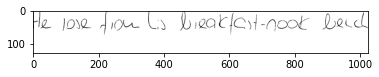

He rose from his breakfast - nook bench
He rose from his breakfarl - nok benh 




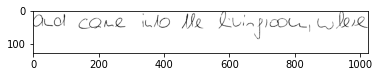

and came into the livingroom , where
and cone into the livingion , where 




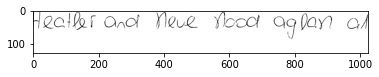

Heather and Steve stood aghast at
Heatler and Meve Hod agean at 




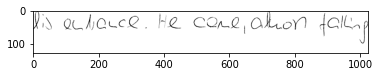

his entrance . He came , almost falling
His enlance . He come , alhon faling 




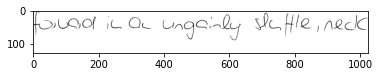

forward in an ungainly shuffle , neck
forward in On ungainly slufle , necld 




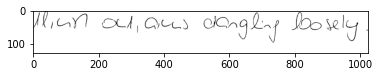

thrust out , arms dangling loosely .
tlinst oul , arus dangling losely . 




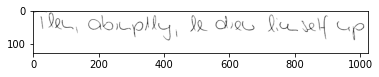

Then , abruptly , he drew himself up
Then , aboimply , be diew lie self up 




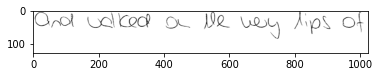

and walked on the very tips of
and volkced on We very lips of 




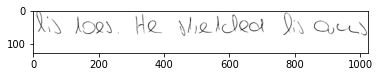

his toes . He stretched his arms
His loes . He sleleded his os 




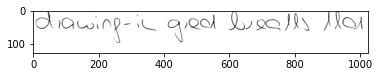

drawing - in great breaths that
drawing - in grel bealks 180 



In [7]:
from data_source import preproc as pp
from matplotlib import pyplot as plt

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=gen.next_test_batch(),
                            steps=gen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [gen.tokenizer.decode(x[0]) for x in predicts]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(FilePaths.output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, gen.dataset['test']['gt']):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

for i, item in enumerate(gen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    plt.imshow(pp.adjust_to_see(item), cmap = "gray", vmin=0, vmax=255)
    plt.show()
    print(gen.dataset['test']['gt'][i])
    print(predicts[i], "\n")

In [27]:
%run Evaluate.ipynb

evaluate = calculate_error(predicts=predicts,
                                  ground_truth=gen.dataset['test']['gt'])

e_corpus = "\n".join([
    f"Total test images:    {gen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / gen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(FilePaths.output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)
    

Total test images:    1425
Total time:           0:00:58.948193
Time per item:        0:00:00.041367

Metrics:
Character Error Rate: 0.07747676
Word Error Rate:      0.24738529
Sequence Error Rate:  0.90105263


Model Predict
1/1 [==============================] - 2s 2s/sample
CTC Decode
1/1 [==============================] - 0s 21ms/step


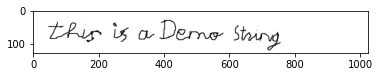

['thin is a Dermo string']


In [8]:
test_image = []
test_image.append(pp.preprocess(FilePaths.test_image_path, input_size=input_size))
test_image = pp.normalization(test_image)

prediction, _= model.predict(test_image, verbose=1, ctc_decode=True)
plt.imshow(pp.adjust_to_see(test_image[0]), cmap ="gray")
plt.show()
prediction = [gen.tokenizer.decode(x[0]) for x in prediction]

print(prediction)

True

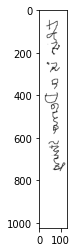

In [56]:
import cv2

preprocessed_img = pp.preprocess(FilePaths.test_image_path, input_size=(1024, 128, 1))
plt.imshow(preprocessed_img, cmap = "gray", vmin=0, vmax=255)
cv2.imwrite(FilePaths.test_image_preprocessed_path, preprocessed_img)

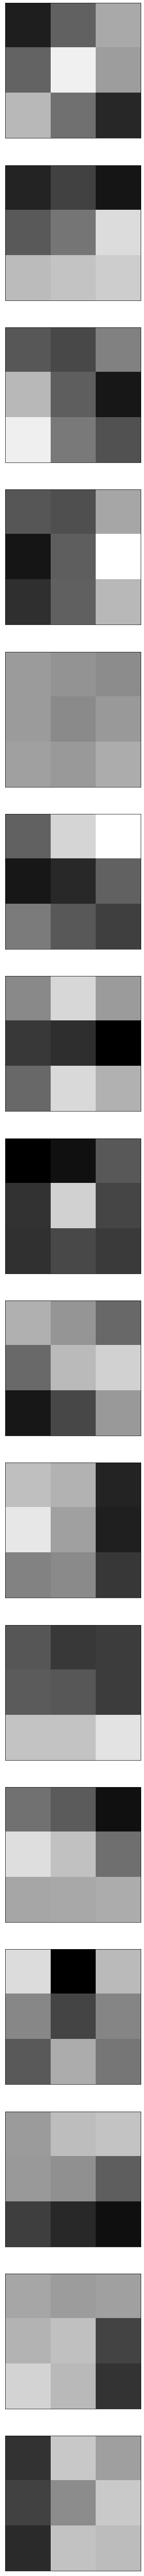

In [134]:
filters, biases = model.model.layers[1].get_weights()

plt.subplots(figsize=(50, 100))

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 1, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray', vmin = 0, vmax=1)
        ix += 1
# show the figure
plt.savefig(FilePaths.cnn_1_weights_path)
plt.show()

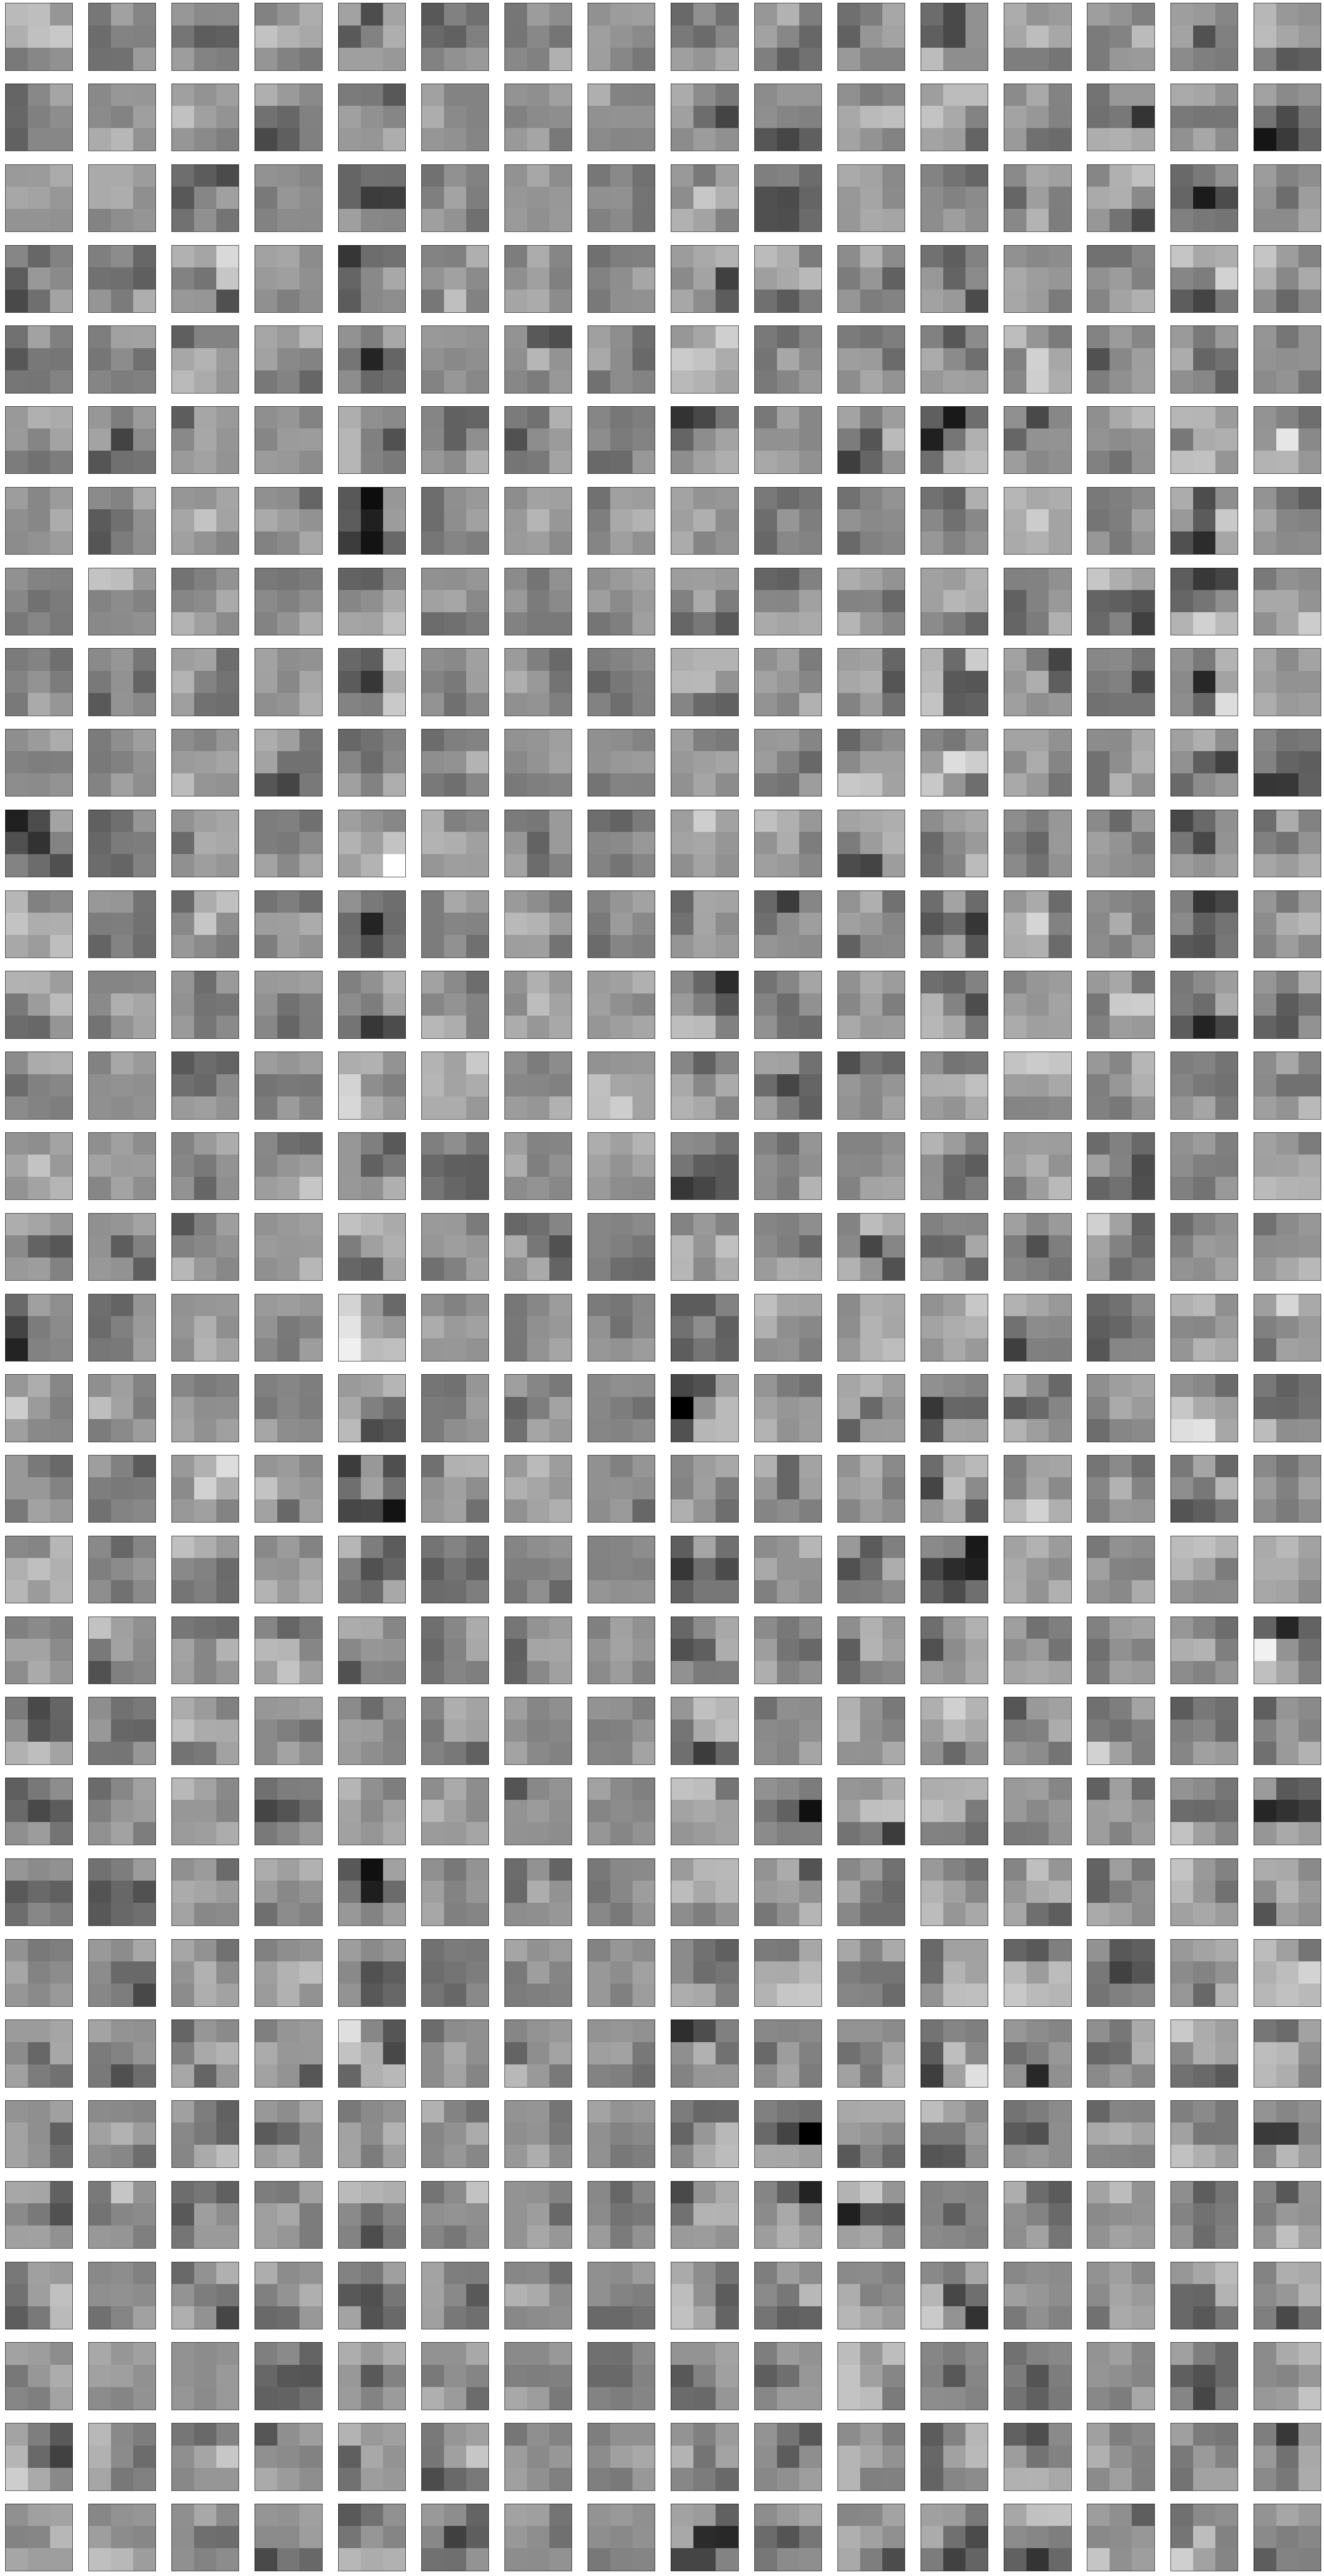

In [132]:
filters, biases = model.model.layers[5].get_weights()

plt.subplots(figsize=(50, 100))

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 32, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(16):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 16, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray', vmin = 0, vmax=1)
        ix += 1
# show the figure
plt.savefig(FilePaths.cnn_2_weights_path)
plt.show()

In [12]:
cnn_1 = Model(model.model.inputs, model.model.layers[4].output)
cnn_2 = Model(model.model.inputs, model.model.layers[8].output)
cnn_3 = Model(model.model.inputs, model.model.layers[13].output)
cnn_4 = Model(model.model.inputs, model.model.layers[17].output)
cnn_5 = Model(model.model.inputs, model.model.layers[21].output)

In [54]:

output_cnn_1 = cnn_1.predict(x=test_image,verbose=1)
output_cnn_2 = cnn_2.predict(x=test_image,verbose=1)
output_cnn_3 = cnn_3.predict(x=test_image,verbose=1)
output_cnn_4 = cnn_4.predict(x=test_image,verbose=1)
output_cnn_5 = cnn_5.predict(x=test_image,verbose=1)

output_cnn_1.shape
output_cnn_2.shape
output_cnn_3.shape
output_cnn_4.shape
output_cnn_5.shape


1/1 [==============================] - 0s 6ms/sample


(1, 128, 16, 80)

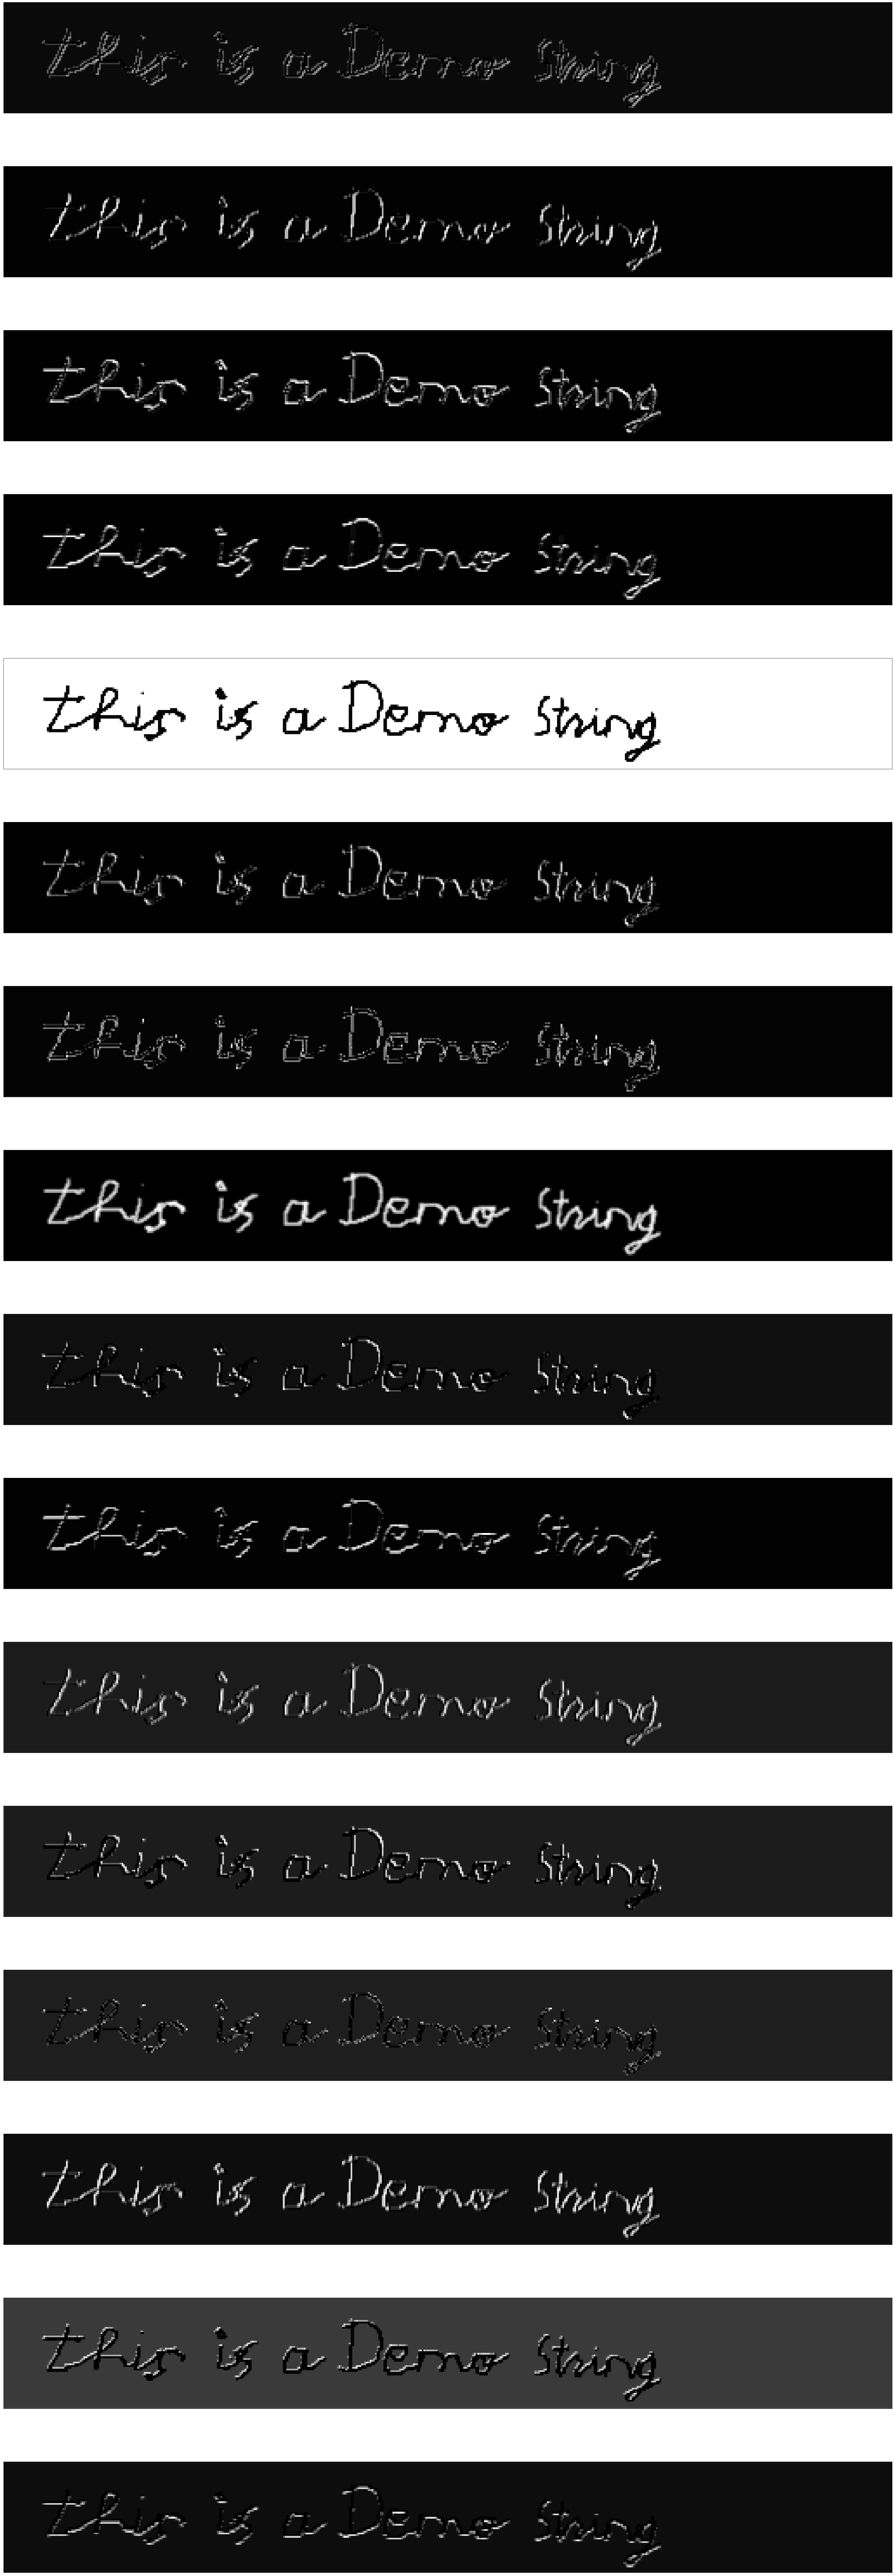

In [122]:
%matplotlib inline
from matplotlib.colors import Normalize

plt.subplots(figsize=(50, 150))
n_filters, ix = 16, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_1[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_1_outputs)
plt.show()
    

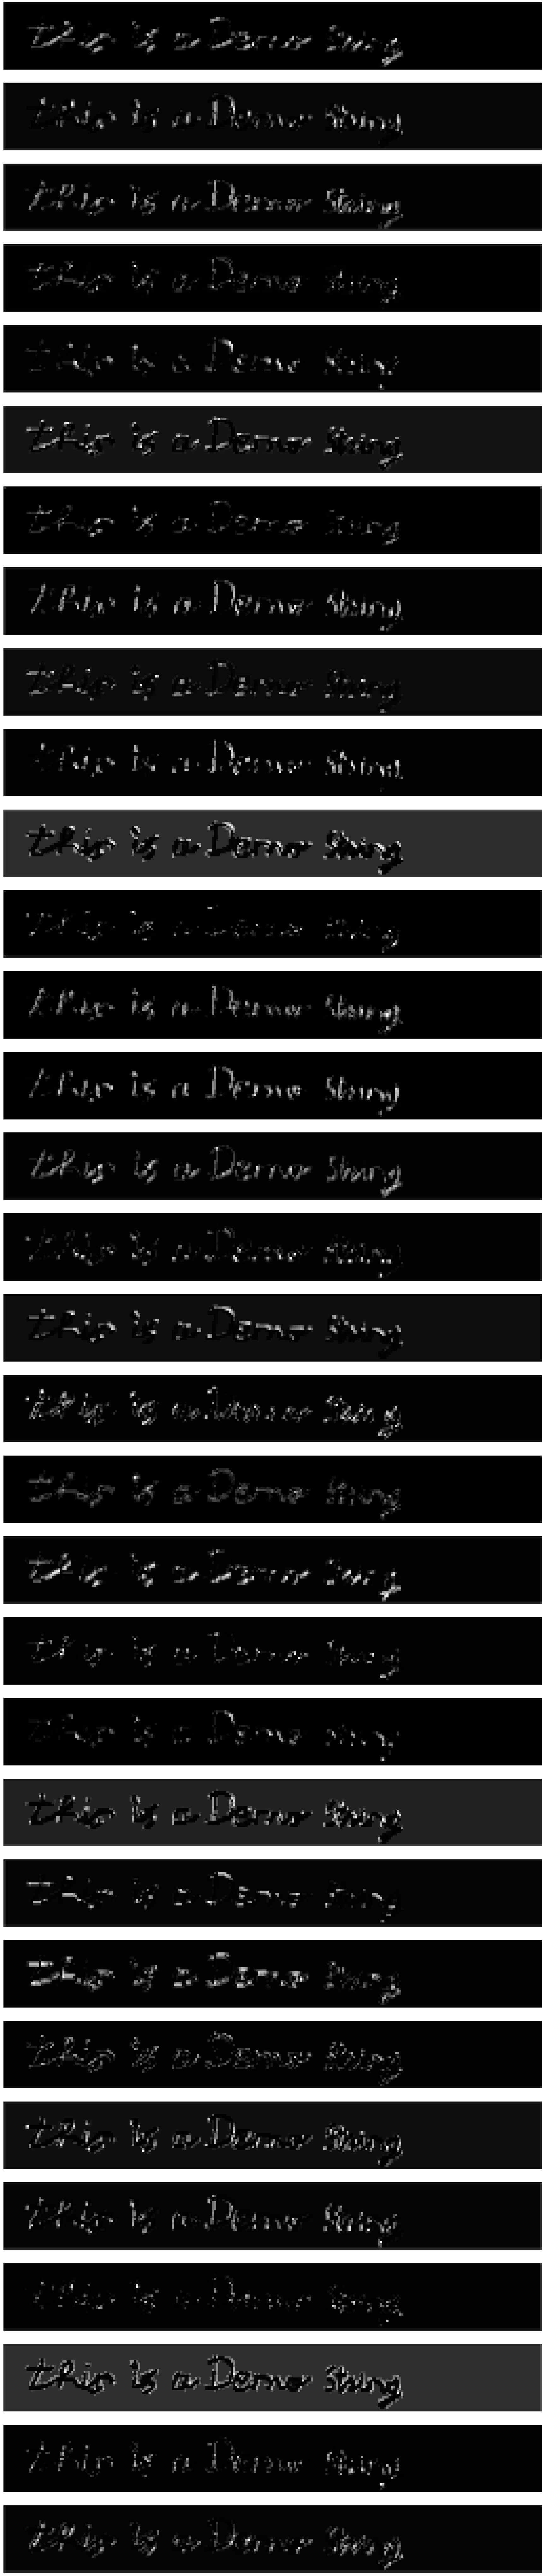

In [107]:
plt.subplots(figsize=(50, 150))
n_filters, ix = 32, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_2[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_2_outputs)
plt.show()

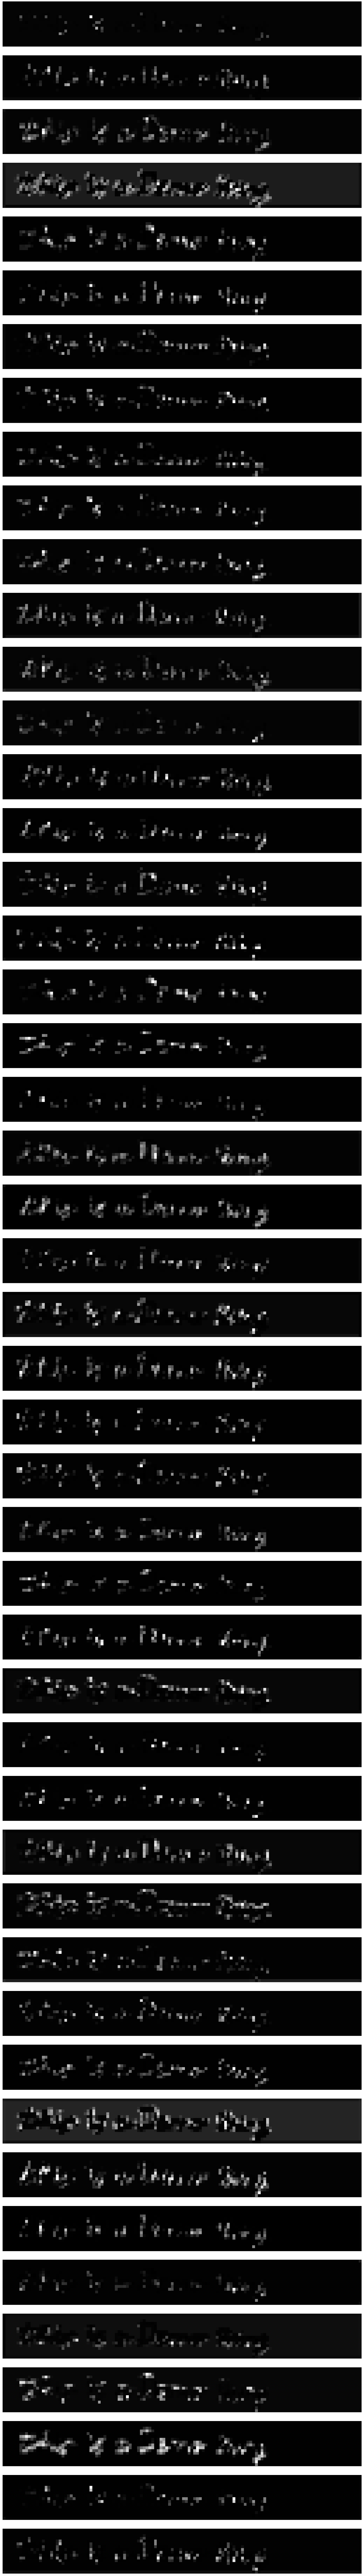

In [114]:
plt.subplots(figsize=(50, 200))
n_filters, ix = 48, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_3[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_3_outputs)
plt.show()

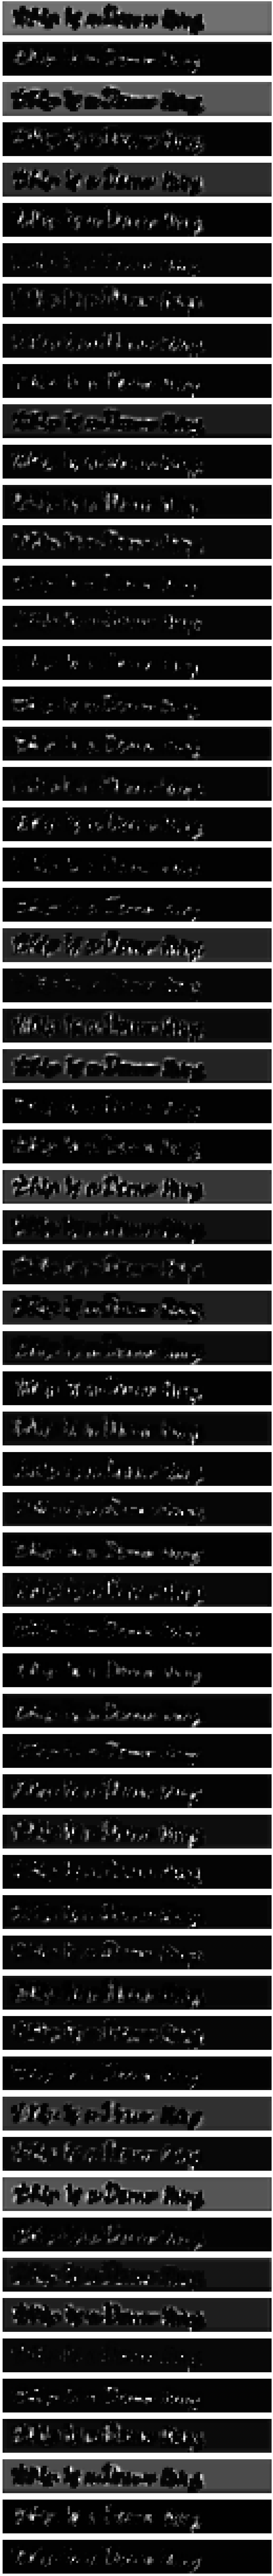

In [116]:
plt.subplots(figsize=(50, 200))
n_filters, ix = 64, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_4[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_4_outputs)
plt.show()

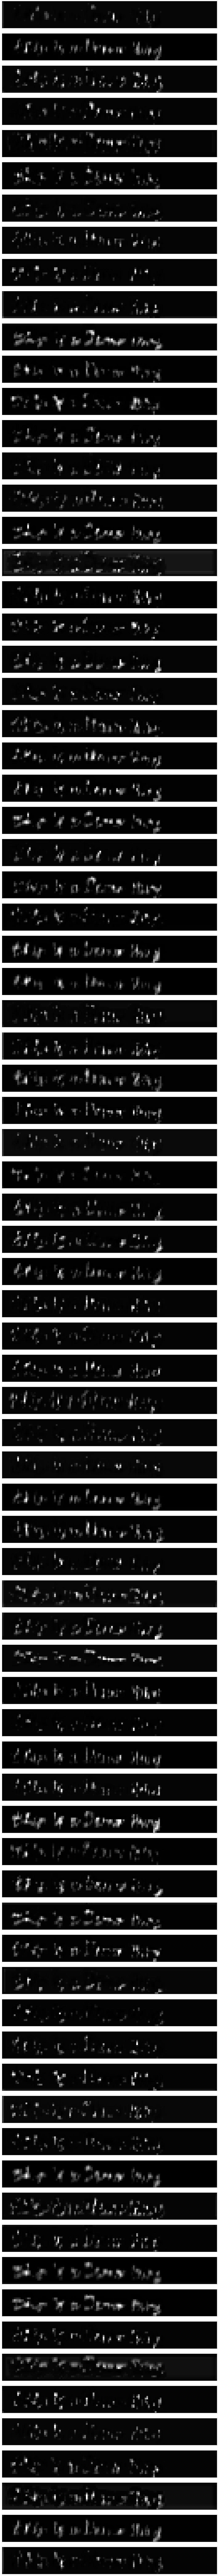

In [123]:
plt.subplots(figsize=(50, 250))
n_filters, ix = 80, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_5[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_5_outputs)
plt.show()